In [1]:
%matplotlib inline

import bisect
import collections
import h5py
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=6)
import sklearn.metrics
import sys
import tensorflow as tf

sys.path.append('../../prediction/')
sys.path.append('../../prediction/neural_networks/')

import batch.dataset_loaders
from neural_networks.updated_network import FFNN

In [2]:
filepath = '../../../data/datasets/oct/subselect_feature_validation_data.h5'
data = batch.dataset_loaders.risk_dataset_loader(
    filepath, 
    target_index=4, 
    timesteps=1, 
    shuffle=True
)
data['y_train'] = np.hstack((1-data['y_train'], data['y_train']))
data['y_val'] = np.hstack((1-data['y_val'], data['y_val']))
ref_data = batch.dataset_loaders.risk_dataset_loader(
    filepath, 
    target_index=4, 
    timesteps=1, 
    shuffle=False, 
    train_split=1.,
    mean=data['means'],
    std=data['stds']
)
ref_data['y_train'] = np.hstack((1-ref_data['y_train'], ref_data['y_train']))
ref_data['y_val'] = np.hstack((1-ref_data['y_val'], ref_data['y_val']))

In [ ]:
data.keys()

In [ ]:
data['x_train'].shape

In [ ]:
print(data['y_train'].shape)
print(np.mean(data['y_train'][:,1]))
print(len(np.where(data['y_train'][:,1] > 0)[0]))
plt.hist(data['y_val'][:,1])

In [ ]:
tf.reset_default_graph()
model = FFNN('test', data['x_train'].shape[-1], dropout_keep_prob=.5)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
model.train(data, n_epochs=10)

In [ ]:
probs, preds = model.predict(ref_data['x_train'])

In [ ]:
# threshold probs
thresh = 1e-8
probs[probs<thresh] = thresh
probs[probs > 1-thresh] = 1-thresh

In [ ]:
losses = -np.sum(ref_data['y_train'] * np.log(probs), axis=-1)

In [ ]:
def absidx2seedidx(absidx, batch_idxs, seeds):
    i = bisect.bisect_left(batch_idxs, absidx)
    if len(batch_idxs) > i and absidx == batch_idxs[i]:
        i += 1
    seed = seeds[i]
    if i > 0:
        veh_idx = absidx - batch_idxs[i - 1] + 1
    else:
        veh_idx = absidx + 1
    return seed, veh_idx

In [ ]:
idxs = list(reversed(np.argsort(losses)))

# idxs = list(reversed(np.argsort(losses)))[:5000]
# nonzero_idxs = np.where(ref_data['y_train'][:,1]==.0)[0]
# idxs = [i for i in idxs if i in nonzero_idxs]


In [ ]:
print(idxs[:10])
print(ref_data['y_train'][idxs][:10])
print(probs[idxs][:10])
print([absidx2seedidx(i, ref_data['batch_idxs'], ref_data['seeds']) for i in idxs[:10]])

In [ ]:
high_idxs = np.where(ref_data['y_train'][:,1] > 0)[0]
low_idxs = np.where(ref_data['y_train'][:,1] == 0)[0]
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(probs[low_idxs,1])
plt.subplot(1,2,2)
plt.hist(probs[high_idxs,1])

In [3]:
def compute_loss(probs, true, thresh=1e-8):
    probs[probs<thresh] = thresh
    probs[probs > 1-thresh] = 1-thresh
    losses = -np.sum(true * np.log(probs), axis=-1)
    return np.mean(losses)

In [4]:
model_stats = dict()
n_epochs = 50
sizes = [1000,2000,5000,10000,20000,50000,100000,1000000]
data['true_x_train'] = np.copy(data['x_train'])
data['true_y_train'] = np.copy(data['y_train'])
for n_samples in sizes:
    print(n_samples)
    data['x_train'] = np.copy(data['true_x_train'][:n_samples])
    data['y_train'] = np.copy(data['true_y_train'][:n_samples])
    
    tf.reset_default_graph()
    model = FFNN(
        'test', 
        data['x_train'].shape[-1], 
        hidden_layer_dims=(128,128,64),
        dropout_keep_prob=1.
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    model.train(data, n_epochs=n_epochs, stop_early=True)
    
    probs, preds = model.predict(data['x_val'])
    val_loss = compute_loss(probs, data['y_val'])
    
    idxs = np.where(data['y_val'] > 0)[0]
    probs, preds = model.predict(data['x_val'][idxs])
    val_loss_nonzero = compute_loss(probs, data['y_val'][idxs])
    
    probs, preds = model.predict(data['x_train'])
    train_loss = compute_loss(probs, data['y_train'])
    
    idxs = np.where(data['y_train'] > 0)[0]
    probs, preds = model.predict(data['x_train'][idxs])
    train_loss_nonzero = compute_loss(probs, data['y_train'][idxs])
    
    
    model_stats[n_samples] = dict(
        val_loss=val_loss, 
        val_loss_nonzero=val_loss_nonzero,
        train_loss=train_loss,
        train_loss_nonzero=train_loss_nonzero
    )
    

1000
epoch: 1 / 50 batch: 10 / 10 loss: 0.22051529996097088

val epoch: 1 / 50 batch: 280 / 280 loss: 0.17322062630472437

epoch: 2 / 50 batch: 10 / 10 loss: 0.13429954871535302

val epoch: 2 / 50 batch: 280 / 280 loss: 0.13584996845706232

epoch: 3 / 50 batch: 10 / 10 loss: 0.09319524094462395

val epoch: 3 / 50 batch: 280 / 280 loss: 0.11735436106765909

epoch: 4 / 50 batch: 10 / 10 loss: 0.059293916821479796

val epoch: 4 / 50 batch: 280 / 280 loss: 0.12310291929835719

epoch: 5 / 50 batch: 10 / 10 loss: 0.04152779951691628

val epoch: 5 / 50 batch: 280 / 280 loss: 0.13207692687865347

2000
epoch: 1 / 50 batch: 20 / 20 loss: 0.2601240176707506

val epoch: 1 / 50 batch: 280 / 280 loss: 0.15960588739586196

epoch: 2 / 50 batch: 20 / 20 loss: 0.1192370180040598

val epoch: 2 / 50 batch: 280 / 280 loss: 0.11963323795768832

epoch: 3 / 50 batch: 20 / 20 loss: 0.07973373103886842

val epoch: 3 / 50 batch: 280 / 280 loss: 0.10791945858259819

epoch: 4 / 50 batch: 20 / 20 loss: 0.0572439555

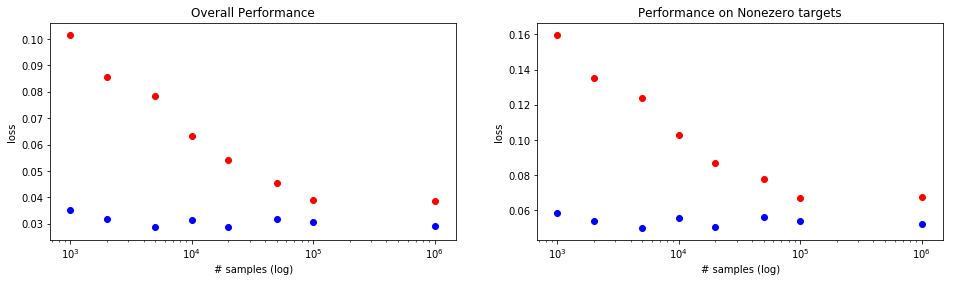

In [6]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('Overall Performance')
plt.gca().set_xscale('log')
plt.xlabel('# samples (log)')
plt.ylabel('loss')
for (n_samples, stats) in model_stats.items():
    plt.scatter(n_samples, stats['val_loss'], c='red')
    plt.scatter(n_samples, stats['train_loss'], c='blue')

plt.subplot(1,2,2)
plt.title('Performance on Nonezero targets')
plt.xlabel('# samples (log)')
plt.ylabel('loss')
plt.gca().set_xscale('log')
for (n_samples, stats) in model_stats.items():
    plt.scatter(n_samples, stats['val_loss_nonzero'], c='red')
    plt.scatter(n_samples, stats['train_loss_nonzero'], c='blue')
plt.show()